RFM Score Calculations

- RECENCY (R): Дни с момента последней покупки
- FREQUENCY (F): Общее количество покупок
- MONETARY VALUE (M): Общая сумма, потраченная этим клиентом

Набор данных, который мы будем использовать - Market Basket - онлайн-набор данных розничной торговли, который можно загрузить из UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/online+retail).

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("Online_Retail.xlsx")
df.head()
df1 = df

Набор данных содержит все транзакции, происходящие в период с 01/12/2010 по 09/12/2011.

Исследуйте данные:

     Пропущенные значения в важных столбцах;
     Распределение клиентов в каждой стране;
     Цена за единицу и количество должны быть большще 0;
     Дата выставления счета должна меньше сегодгяшней даты.

In [4]:
df1.Country.nunique()

38

In [5]:
df1.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Malta', 'RSA'], dtype=object)

In [6]:
customer_country=df1[['Country','CustomerID']].drop_duplicates()

customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


Более 90% клиентов в данных из Великобритании. Некоторые исследования показывают, что клиентские кластеры различаются в зависимости от географии.

In [7]:
df1 = df1.loc[df1['Country'] == 'United Kingdom']

In [8]:
df1 = df1[pd.notnull(df1['CustomerID'])]

In [9]:
df1 = df1[pd.notnull(df1['CustomerID'])]

In [10]:
df1.Quantity.min()

-80995

In [11]:
df1 = df1[(df1['Quantity']>0)]
df1.shape
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null datetime64[ns]
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [12]:
def unique_counts(df1):
   for i in df1.columns:
       count = df1[i].nunique()
       print(i, ": ", count)
unique_counts(df1)

InvoiceNo :  16649
StockCode :  3645
Description :  3844
Quantity :  294
InvoiceDate :  15615
UnitPrice :  403
CustomerID :  3921
Country :  1


In [13]:
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']

In [14]:
df1['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [15]:
df1['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [16]:
import datetime as dt
NOW = dt.datetime(2011,12,10)

df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

In [17]:
rfmTable = df1.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [18]:
rfmTable.head(5)

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


Интерпретация:

     CustomerID 12346 имеет периодичность: 1, денежная стоимость: 77 183,60 долл. США и периодичность: 325 дней.
     CustomerID 12747 имеет периодичность: 103, денежная стоимость: 4 196,01 долл. США и периодичность: 2 дня.

Давайте проверим детали первого клиента.

In [20]:
first_customer = df1[df1['CustomerID']==12346.0]

In [21]:
first_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


Первый покупатель совершил покупки только один раз, купив один товар в огромном количестве (74 215). Цена за единицу очень низкая; возможно распродажа.

Разделить метрики

Самый простой способ разбить метрики на сегменты - использовать квартили.

     Это дает нам отправную точку для подробного анализа.
     4 сегмента легко понять и объяснить.

In [22]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [23]:
segmented_rfm = rfmTable

In [24]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [25]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


Сегменты RFM разделяют клиентскую базу на воображаемый трехмерный куб, который трудно визуализировать. Тем не менее, мы можем разобраться.

Добавьте новый столбец, чтобы объединить оценку RFM: 111 является самой высокой оценкой, как мы определили ранее.

In [27]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


Очевидно, что первый клиент вовсе не наш лучший клиент.

In [28]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
18102.0,0,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
17511.0,2,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
13694.0,3,568,65039.62,1,1,1,111
15311.0,0,2379,60767.90,1,1,1,111
13089.0,2,1818,58825.83,1,1,1,111
15769.0,7,130,56252.72,1,1,1,111


Итак наши клиенты:

Лучшие клиенты - 111 покупали недавно и чаще всего тратят много денег. Неценовые стимулы - новые продукты и программы лояльности

Лояльные клиенты - X1X покупают чаще всего. Используйте R и M для дальнейшего сегментации

Большие расходы - XX1 Клиенты, которые тратят больше всего. Продавайте свои самые дорогие продукты.

Почти утеряные клиенты - 311 Не покупался в течение некоторого времени, но покупал часто и тратил больше всего. Агрессивный ценовой стимул.

Потерянные клиенты - 411 Не покупали в течение некоторого времени, но покупали часто и тратят больше всего. Агрессивные ценовые стимулы.

Потерянные дешевые клиенты - 444 Последняя покупка давно, куплена мало и тратили мало. Не тратьте слишком много, пытаясь заново их приобрести.

In [31]:
segmented_rfm.groupby('RFMScore').agg('monetary_value').mean()

RFMScore
111     8218.150196
112     1121.406667
113      496.658125
114      272.440000
121     4469.872436
122     1085.538306
123      462.946923
124      208.206154
131     2872.560000
132      881.123250
133      454.136970
134      213.351429
141    38649.440000
142     1081.549231
143      395.989048
144      164.389153
211     4114.533978
212     1087.312410
213      565.482778
221     3491.008868
222     1046.864878
223      457.622857
224      224.581200
231     3054.722727
232      886.718367
233      469.026542
234      194.347500
241     2478.824286
242     1020.809286
243      424.008788
           ...     
311     2907.782174
312     1085.662564
313      507.820833
321     2629.319608
322     1024.795352
323      466.020625
324      215.190952
331     2739.223750
332      936.701558
333      450.168447
334      188.441190
341     2591.682857
342      923.071852
343      422.437861
344      166.338929
411     2808.919550
412     1017.806842
413      481.195000
421     288

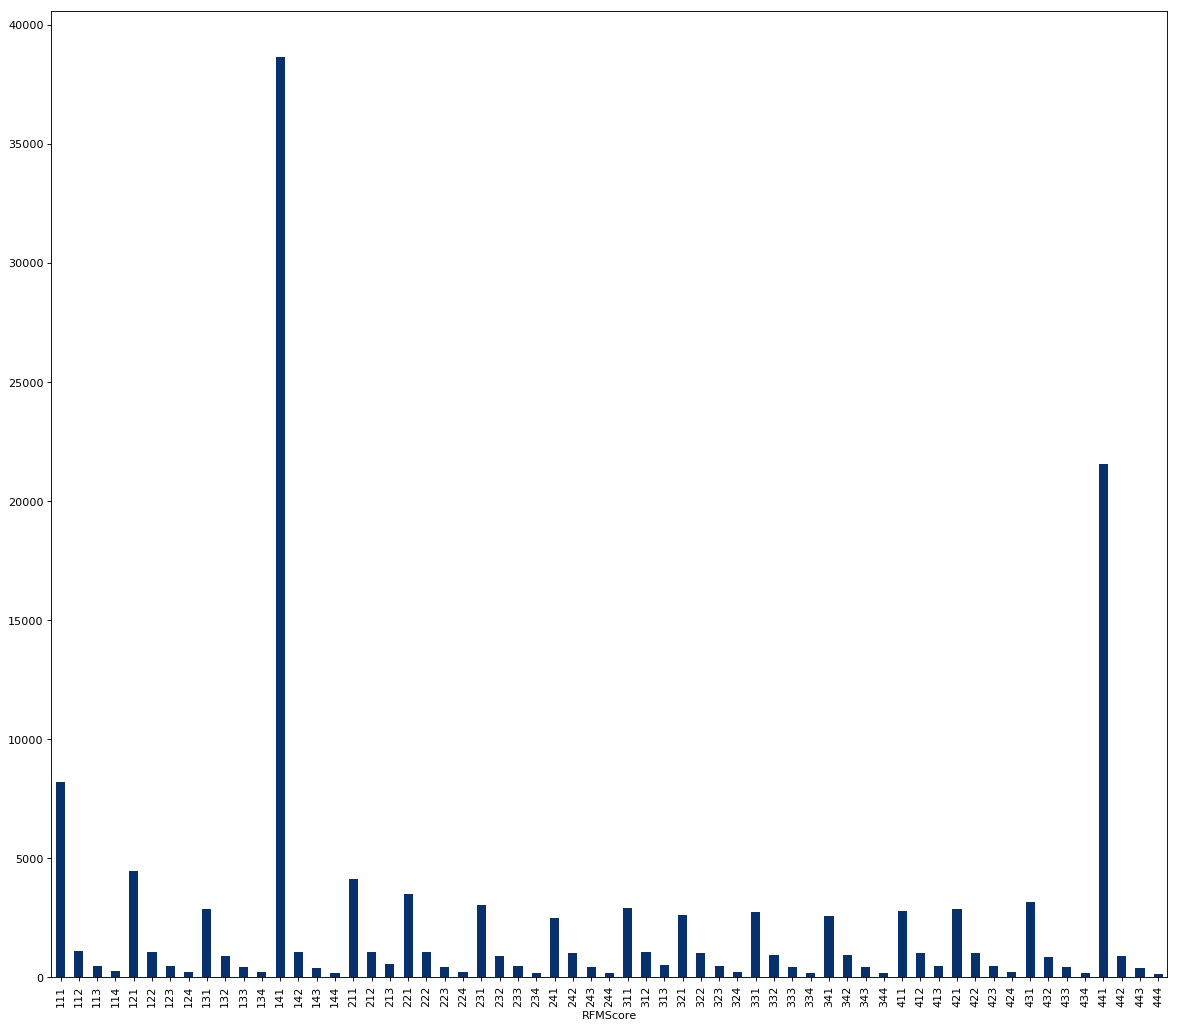

In [37]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

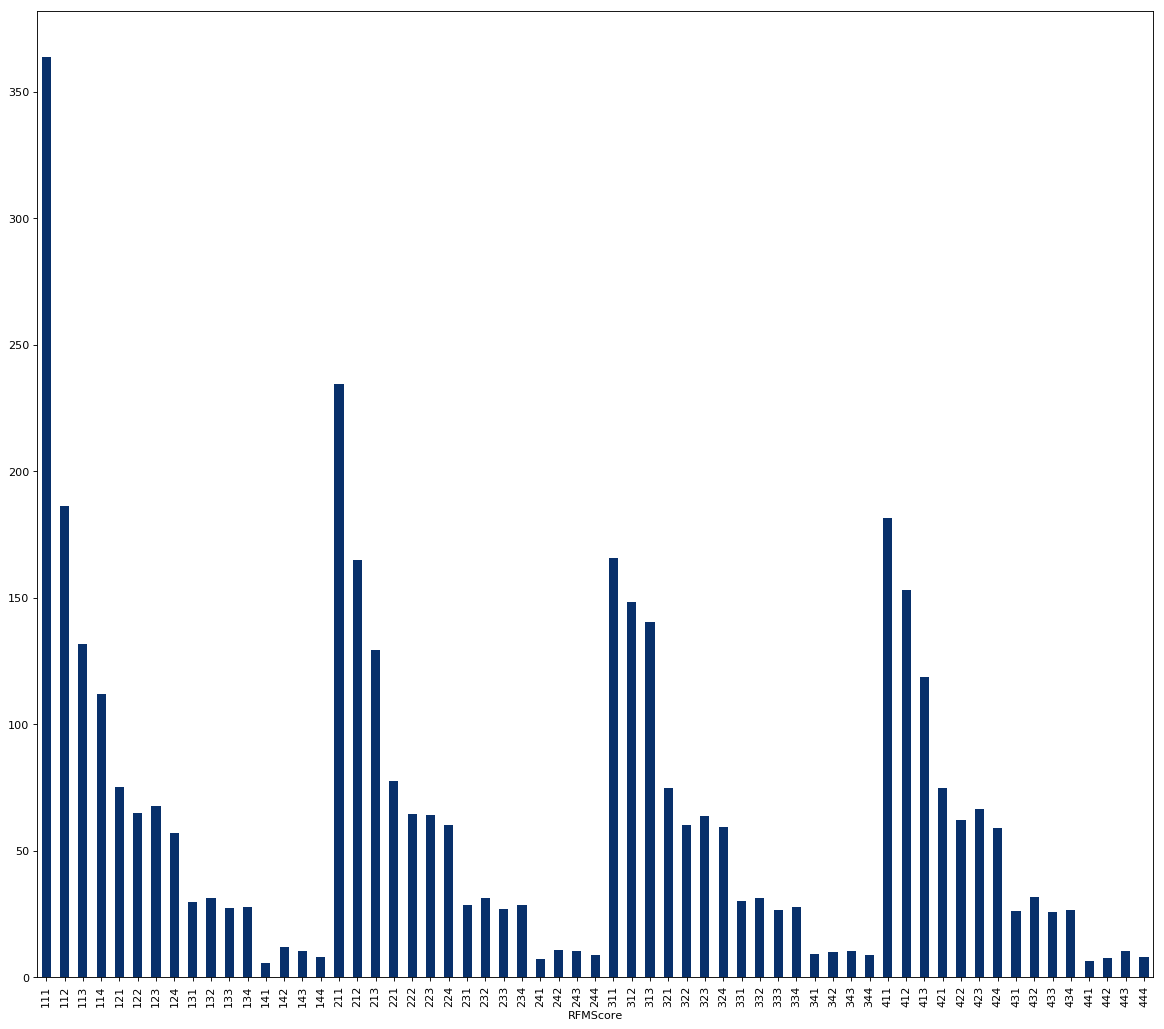

In [39]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

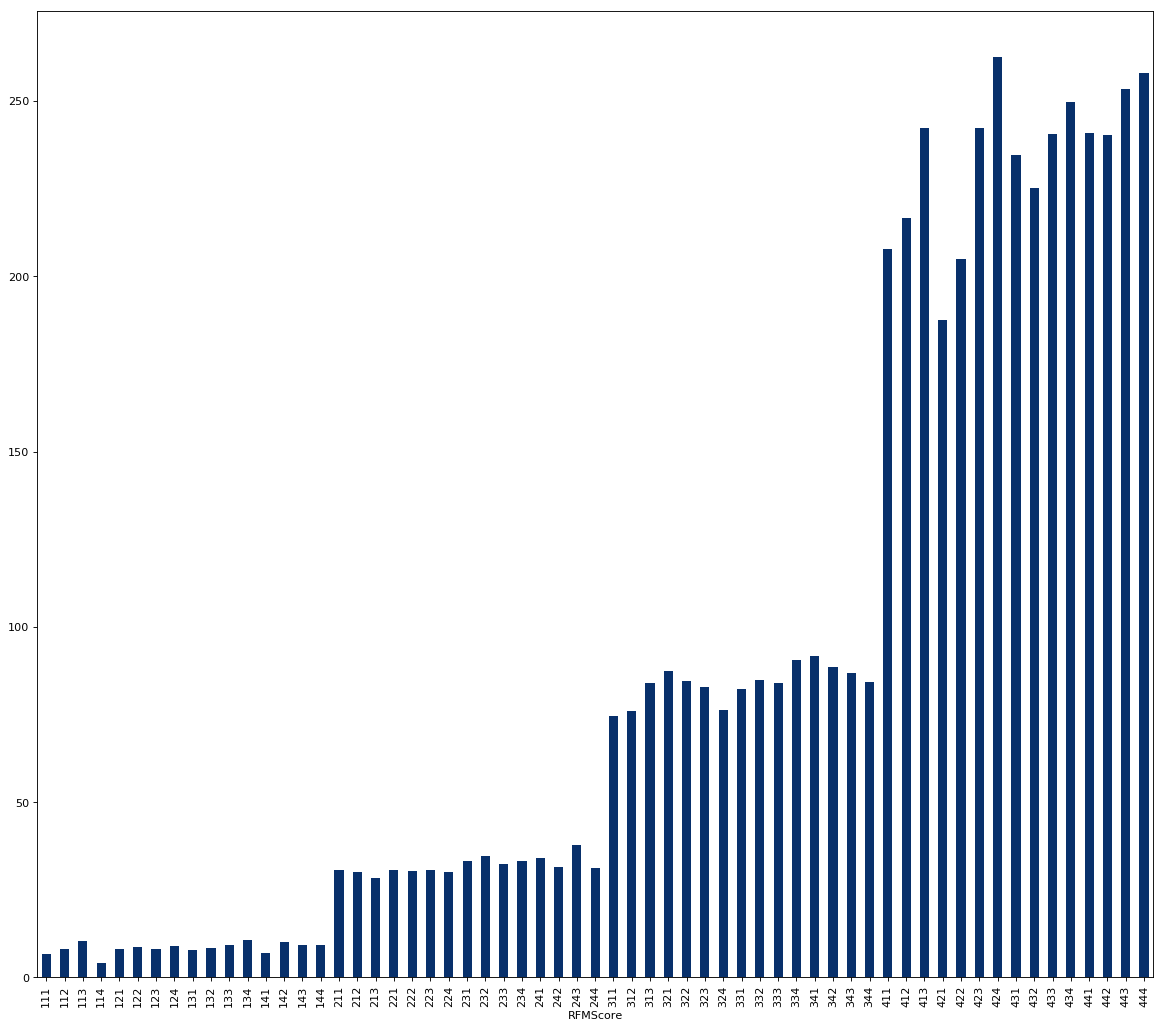

In [40]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()